# Задача 1. Логистическая регрессия.

Для идентификации параметров линейного классификатора методом логистической регрессии требуется найти минимум функции [риска](http://www.machinelearning.ru/wiki/index.php?title=Логистическая_регрессия):

$$
Q(\omega) = \sum_{i=1}^m ln(1+ e^{-y_i\cdot<x_i,\omega>})
$$
 
Для любого $\omega \in R^{n+1}$, где $x_i \in R^{n+1}$, $y_i \in \{-1, 1\}$ первая координата всех  векторов $x$ равна $-1 (x_i^0= -1)$. Остальные координаты и конкретные значения $y$ требуется получить следующим образом:

- Смоделировать данные как точки двух классов $(-1, +1)$ на плоскости $(n = 2)$ (разделимые прямой и не разделимые прямой). 
- Тоже, но точки в трехмерном пространстве $(n = 3)$. (Разделимые и не разделимые гиперплоскостью соответственно.)


__Задание:__
1. Реализовать алгоритм градиентного спуска средствами любого удобного для этих целей языка программирования, описать его для данной задачи и протестировать для различных начальных приближений. Отобразить на рисунках сгенерированное множество точек, гиперплоскость начального приближения и результирующую разделяющую гиперплоскость.
2. Значение градиента требуется посчитать аналитически (при выводе аналитических формул удобно использовать обозначение $\sigma(M) = \frac{1}{1 + e^{-M}}$).
3. Построить графики зависимости количества итераций алгоритма от требуемой точности $N(\log(\frac{1}{\varepsilon}))$. При начальном одном и том же начальном приближении. Сравнить различные стратегии выбора шагов.
4. Тоже, что в предыдущих пунктах, но использовать метод Ньютона-Рафсона.
5. Построить разделяющую поверхность с помощью [линейного дискриминантного анализа](https://en.wikipedia.org/wiki/Linear_discriminant_analysis#LDA_for_two_classes). При генерации данных используйте гипотезу линейного дискриминантного анализа (точки каждого класса выбраны из нормального распределения со своим математическим ожиданием и одинаковой дисперсией).  Сравнить результаты. Проведите оценку методом скользящего контроля q-fold со случайно перемешанной выборкой.
6. Применить разработанный алгоритм к решению любой тестовой задачи машинного обучения с количеством числовых признаков $n > 10$ ([например](https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738)).

## Решение:

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score

%config InlineBackend.figure_format="retina"
sns.set(style='darkgrid', font_scale=1.4,palette='Set2')
np.random.seed(42)
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### Datasets generation.

#### Линейно разделимые данные.

In [2]:
N=200
SIGMA=10

In [3]:
sample = sps.norm(scale=SIGMA).rvs(size=(N, 2))
X_l = np.hstack((np.ones(sample.shape[0])[:, None], sample))
w_true = np.array([0, 1, 2])
y_l = ((X_l * w_true).sum(axis=1) > 0) * 2 - 1

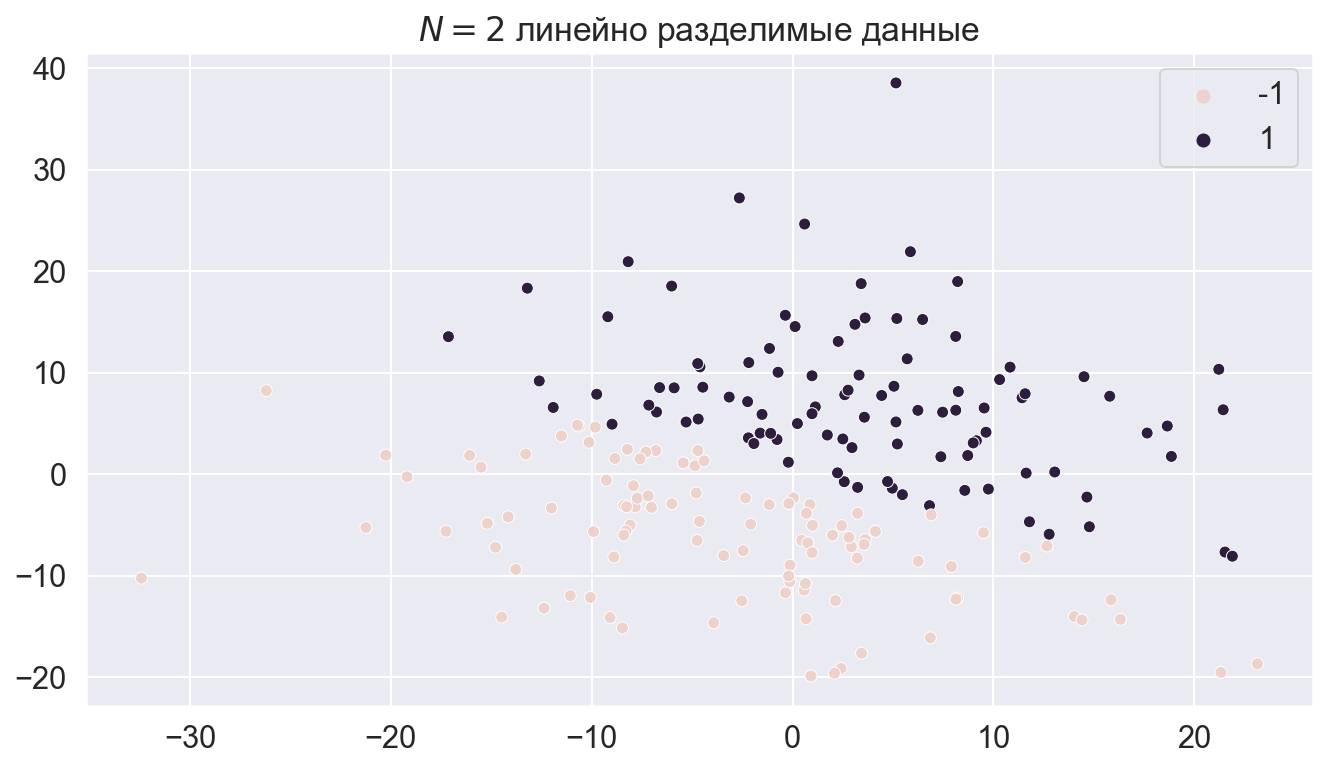

In [4]:
fig, axis = plt.subplots(figsize=(11, 6))
plt.title(r'$N = 2$ линейно разделимые данные')
sns.scatterplot(x=X_l[:, 1], y=X_l[:, 2], hue=y_l)
plt.show()

#### Не разделимый линейно случай.

In [5]:
X_nl, y_nl = make_circles(N, factor=.1, noise=.1)
X_nl = np.hstack((np.ones(X_nl.shape[0])[:, None], X_nl))
y_nl[y_nl == 0] = -1

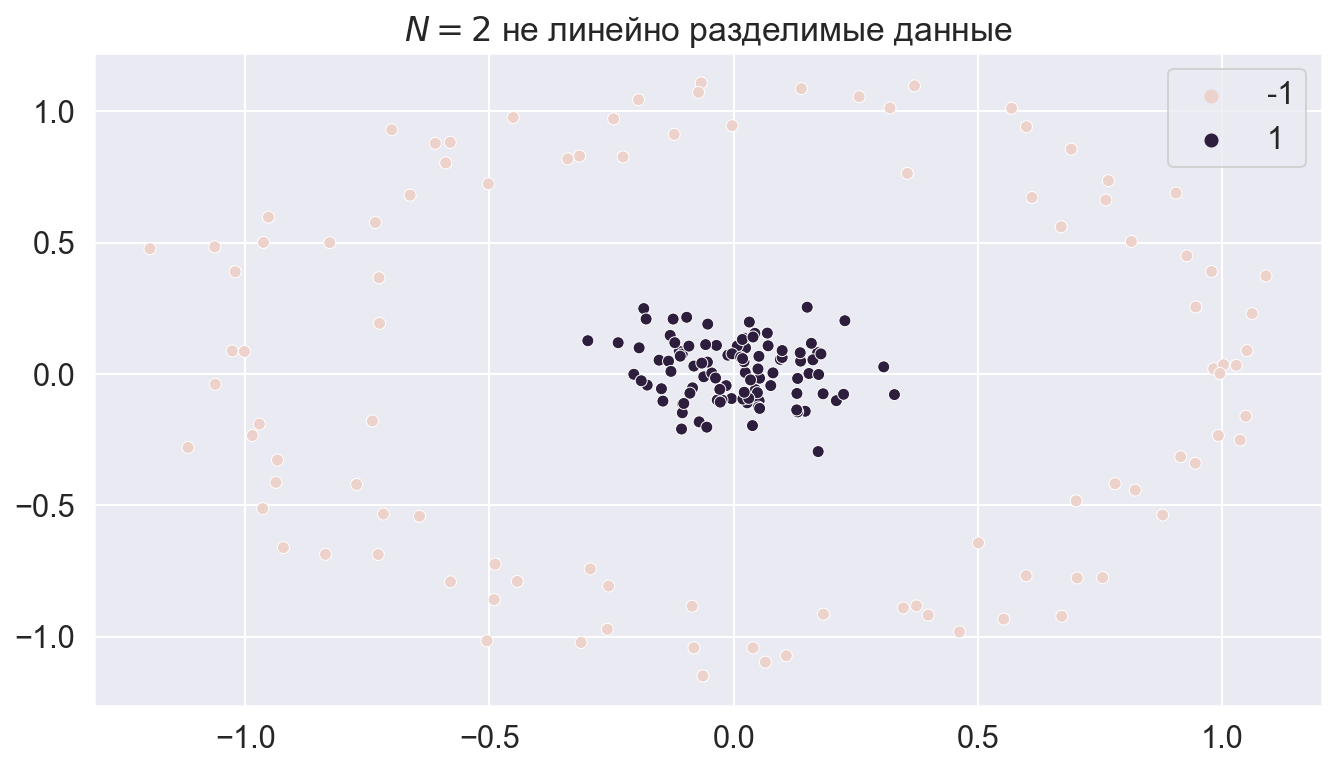

In [6]:
fig, axis = plt.subplots(figsize=(11, 6))
plt.title(r'$N = 2$ не линейно разделимые данные')
sns.scatterplot(x=X_nl[:, 1], y=X_nl[:, 2], hue=y_nl)
plt.show()

### GD method.

Используя градиентный спуск, вектор весов $\mathbf{w}^{(t+1)}$ на шаге $t+1$ можно записать следующим образом:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla Q(\mathbf{w}^{(t)}),
$$

Градиент функции потерь в таком случае:

$$
\mathop{\nabla_{\mathbf{w}}} Q(\mathbf{w}) = \sum_{i=1}^N x_i {{-y_i \exp(−y_i <x_i, \mathbf{w}>)} \over {1 + \exp(−y_i <x_i, \mathbf{w}>)}}
$$

In [7]:
from sklearn.base import BaseEstimator

In [8]:
class LogRegression(BaseEstimator):
    
    def __init__(self, fit_intercept: bool = True, initial_step: float = 3*1e-3, 
                 precision: float = 1e-4, increasing_enabled=True, initial_w: np.array = None):
        self.fit_intercept = fit_intercept
        self.w = None if initial_w is None else self.vector_normalize(initial_w)
        self.iter_count = 0
        self.initial_step = initial_step
        self.precision = precision
        self.inc_enabled = increasing_enabled
        self.MAX_ITER_CNT = 1e5
        
    def vector_normalize(self, vec: np.array):
        shift = 1 if self.fit_intercept else 0 
        return vec / np.linalg.norm(vec[shift:])
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack((np.ones(X.shape[0])[:, None], X))
        if self.w is None:
            initial_w = np.random.uniform(-2, 2, X.shape[1]) # np.array([-1, 1, -1])
            self.w = self.vector_normalize(initial_w)
        self.gradient_descent(X, y)
        return self
    
    def predict(self, X) -> np.array:
        if self.fit_intercept:
            X = np.hstack((np.ones(X.shape[0])[:, None], X))
        result = ((X @ self.w) > 0).astype(int)
        result[result == 0] = -1
        return result
        
        
    def gradient_descent(self, X: np.array, y: np.array):
        step = self.initial_step
        curQ = LogRegression.LRloss(X, y, self.w)
        iters_wo_lessening_step = 0
        while self.precision < step and self.iter_count < self.MAX_ITER_CNT:
            self.iter_count += 1
            grad = LogRegression.LossDerivative(X, y, self.w)
            nw = self.vector_normalize(self.w - step * grad)
            newQ = LogRegression.LRloss(X, y, nw)
            if curQ - newQ <= 1e-9:
                step *= 0.5
                iters_wo_lessening_step = 0
                continue
            iters_wo_lessening_step += 1
            if self.inc_enabled and iters_wo_lessening_step > 10:
                step *= 1.2
            curQ = newQ
            self.w = nw
        return
    
    def get_params(self, **params):
        return self.w

    def get_iter_count(self):
        return self.iter_count
    
    @staticmethod
    def LRloss(X, y, w):
        return np.log(1 + np.exp(-(X * w).sum(axis=1) * y)).sum()
    
    @staticmethod
    def LossDerivative(X, y, w):
        exp = np.exp(-(X * w).sum(axis=1) * y)
        return (X.T * (-y * exp / (1 + exp))).sum(axis=1)

In [9]:
# works only in 2D case
def plot_decision_regions(X, y, w):
    plt.figure(figsize=(11, 8))
    sns.scatterplot(x=X[:, 1], y=X[:, 2], hue=y)
    if w[2] != 0:
        x = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
        y = -(x * w[1] + w[0]) / w[2]
        plt.plot(x, y, label='Результирующая гиперплоскость')
    axis.set_xlim((np.min(X[:, 1]), np.max(X[:, 1])))
    axis.set_ylim((np.min(X[:, 2]), np.max(X[:, 2])))
    plt.show()

Проверим на линейно разделимых данных.

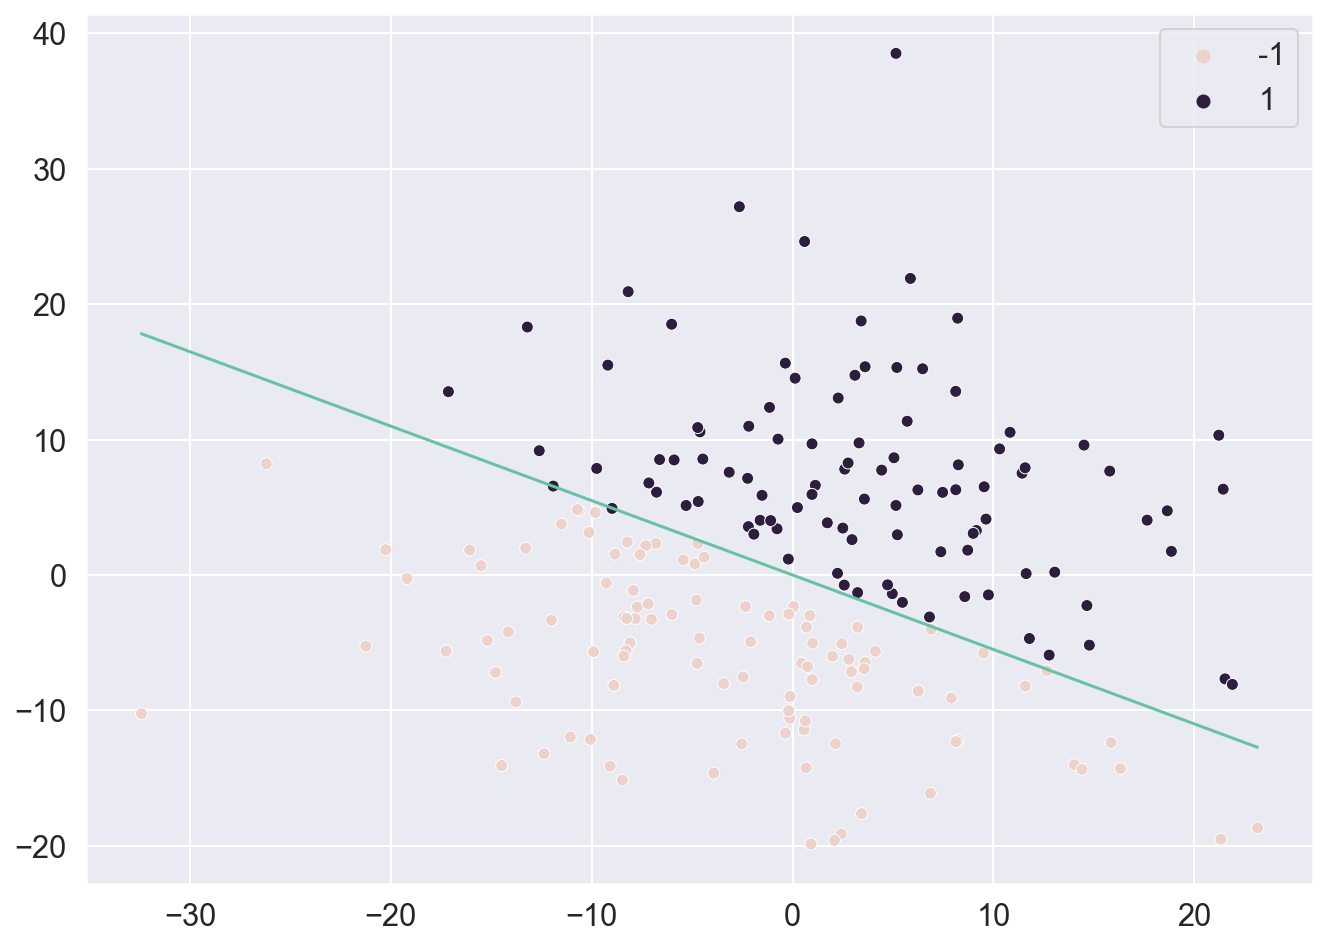

In [10]:
lr_l = LogRegression(fit_intercept=False).fit(X_l, y_l)
plot_decision_regions(X_l, y_l, lr_l.get_params())

In [11]:
y_l_pred = LogRegression(fit_intercept=False).fit(X_l, y_l).predict(X_l)
print('Accuracy score is', accuracy_score(y_l, y_l_pred))

Accuracy score is 0.995


Проверим на данных, которые не разделимы линейно.

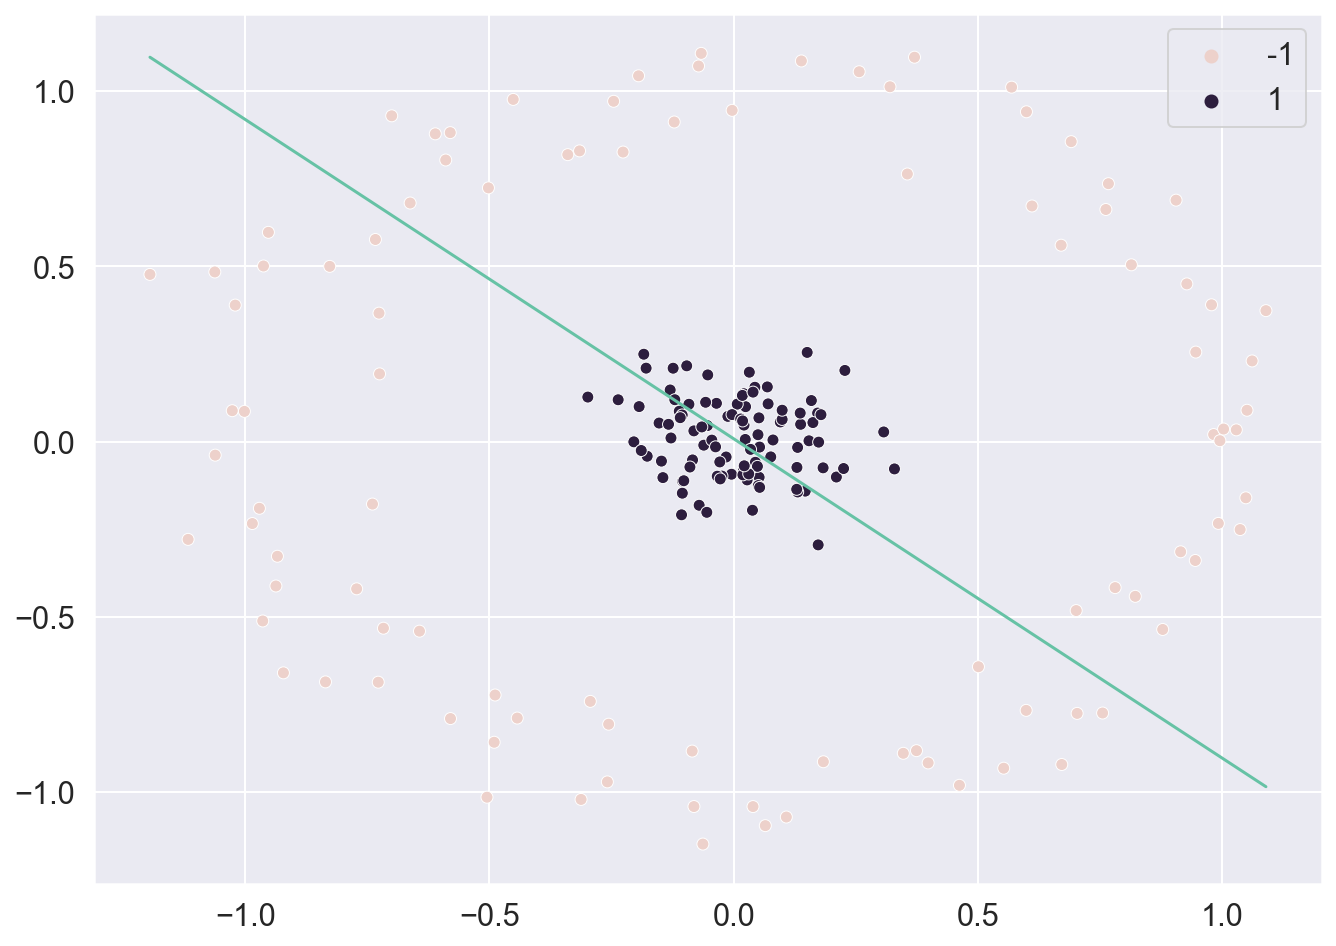

In [12]:
lr_nl = LogRegression(fit_intercept=False).fit(X_nl, y_nl)
plot_decision_regions(X_nl, y_nl, lr_nl.get_params())

In [13]:
y_nl_pred = LogRegression(fit_intercept=False).fit(X_nl, y_nl).predict(X_nl)
print('Accuracy score is', accuracy_score(y_nl, y_nl_pred))

Accuracy score is 0.51


Как и ожидалось Логистическая регрессия с hand-made градиентным спуском отлично справилась с линейно разделимым случаем и не справилась с данным, которые не разделимы линейно.

### Исследование зависимости количества итераций от требуемой точности 

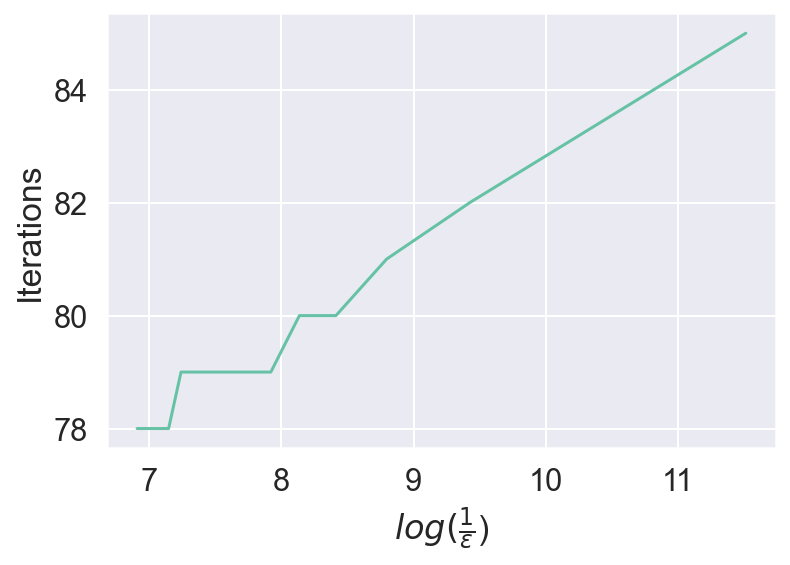

In [14]:
grid_eps = np.linspace(1e-5, 1e-3, 15)
initial_w = np.array([0, -1, 1])
steps = np.zeros_like(grid_eps)
for i, eps in enumerate(grid_eps):
    steps[i] = LogRegression(
        fit_intercept=False, 
        initial_w=initial_w,
        precision=eps).fit(X_l, y_l).get_iter_count()
plt.plot(np.log(1/grid_eps), steps)
plt.ylabel('Iterations')
plt.xlabel(r'$log(\frac{1}{\varepsilon}$)')
plt.show()

Видим, что при увеличении требуемой точности алгоритма количество шагов для сходимости увеличивается, причем зависимость с какого-то момента напоминает линейную.

## Метод Ньютона-Рафсона

С помощью метода Ньютона для поиска минимума функции будем искать точку, где градиент $\nabla_\mathbf{w} Q(\mathbf{w}) = 0$.  
Формула пересчета на каждом шаге будет выглядеть следующим образом: 
$$\mathbf{w}_{k+1} = \mathbf{w}_k - \lambda_k(\nabla_\mathbf{w}^2Q(\mathbf{w}_k))^{-1}\nabla_\mathbf{w} Q(\mathbf{w}_k)$$

где в случае метода Ньютона-Рафсона 
$$\lambda_k = argmin_{\lambda} Q(\mathbf{w}_k - \lambda_k(\nabla_\mathbf{w}^2Q(\mathbf{w}_k))^{-1}\nabla_\mathbf{w} Q(\mathbf{w}_k))$$  

Значение градиента мы уже знаем: 
$$
\mathop{\nabla_{\mathbf{w}}} Q(\mathbf{w}) = \sum_{i=1}^N x_i {{-y_i \exp(−y_i <x_i, \mathbf{w}>)} \over {1 + \exp(−y_i <x_i, \mathbf{w}>)}}
$$ 
Найдем матрицу Гесса:  
$$
\frac{\partial \nabla Q_j}{\partial \mathbf{w}_k} = \frac{\partial \big(\sum\limits_{i=1}^{m}\frac{y_i}{1+exp(-y_i\cdot x_i^T\mathbf{w})}x_{ij} \big)}{\partial \mathbf{w}_k} = \sum\limits_{i=1}^m\frac{-y_i}{(1+exp(-y_i\ \cdot x_i^T\mathbf{w}))^2}e^{-y_i \cdot x_i^T\mathbf{w}}x_{ij}(-y_ix_{ik})  
$$
Итак,
$$
\nabla_\mathbf{w}^2 Q(w) = \sum\limits_{i=1}^m\frac{{y_i}^2}{(1+exp(-y_i\ \cdot x_i^Tw))^2}e^{-y_i \cdot x_i^Tw}x_{i}x_{i}^T
$$

In [15]:
from numpy import linalg as LA

In [16]:
def evaluate_gessian(X, y, w):
    tmp = (y**2) * (1 / (1 + np.exp(-y * (X @ w)))) * np.exp(-y * (X @ w))
    m = len(X)
    res = np.zeros((len(w), len(w)))
    tmp = tmp.flatten()
    for i in range(len(X)):
        res += tmp[i] * (X[i][:, None] * X[i])
    return res

def evaluate_gradient(X, y, w):
    return X.T @ (-y * (1 / (1 + np.exp(-y * (X @ w)))) * np.exp(-y * (X @ w)))

def evaluate_func(X, y, w):
    return np.log(1 + np.exp(-y * (X @ w))).sum()

def evaluate_argmin(X, y, w, vec, eps=0.001):
    l, r = 0, 100
    while r - l > eps:
        m1, m2 = l + (r - l) / 3, r - (r - l) / 3
        if evaluate_func(X, y, w + m1 * vec) > evaluate_func(X, y, w + m2 * vec):
            l = m1
        else:
            r = m2
    return (l + r) / 2

In [17]:
def newton_rafson_method(x, y, w0, eps, get_steps=False):
    w, n_steps = w0, 0
    while True:
        grad = evaluate_gradient(x, y, w)
        gess = evaluate_gessian(x, y, w)
        
        v = np.linalg.inv(gess) @ grad
        
        step = evaluate_argmin(x, y, w, -v, eps=eps/10)
        
        w_old = w.copy()
        w = w - step * v
        n_steps += 1
        
        if LA.norm(w - w_old) < eps:
            break
    return (w, n_steps) if get_steps else w

In [18]:
w0 = np.array([[1],[2],[1]])

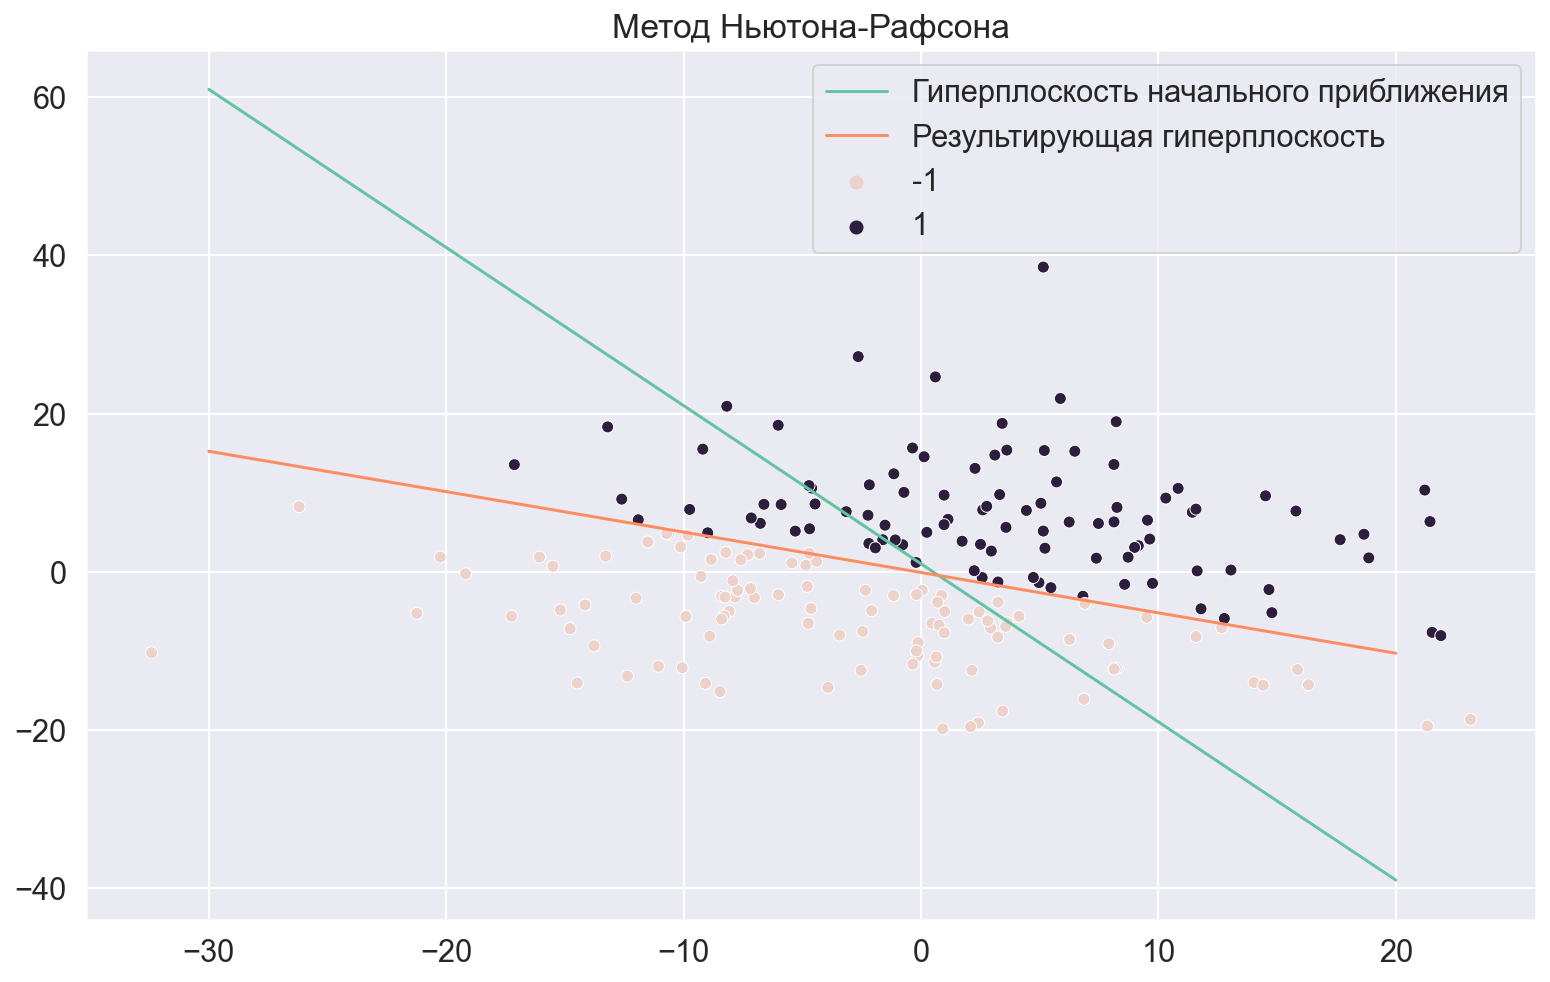

In [19]:
plt.figure(figsize=(13, 8))
sns.scatterplot(x=X_l[:, 1], y=X_l[:, 2], hue=y_l)

x = np.linspace(-30, 20, 400)
y0 = (w0[0] - w0[1] * x) / w0[2]
plt.plot(x, y0, label='Гиперплоскость начального приближения')

w = newton_rafson_method(X_l, y_l[:, np.newaxis], w0, 0.01)
w = w.flatten()
y = (w[0] - w[1] * x) / w[2]
plt.plot(x, y, label='Результирующая гиперплоскость')

plt.legend(loc='best')
plt.title('Метод Ньютона-Рафсона')
plt.show()

Посмотрим на то как ведет себя метод Ньютона-Рафсона при различных начальных приближениях.

In [20]:
different_w0 = np.array([
    np.array([-1, -1, -1]),
    np.array([10, 1, 2]),
    np.array([10, -1, 1]),
    np.array([3, 0, -2])
])

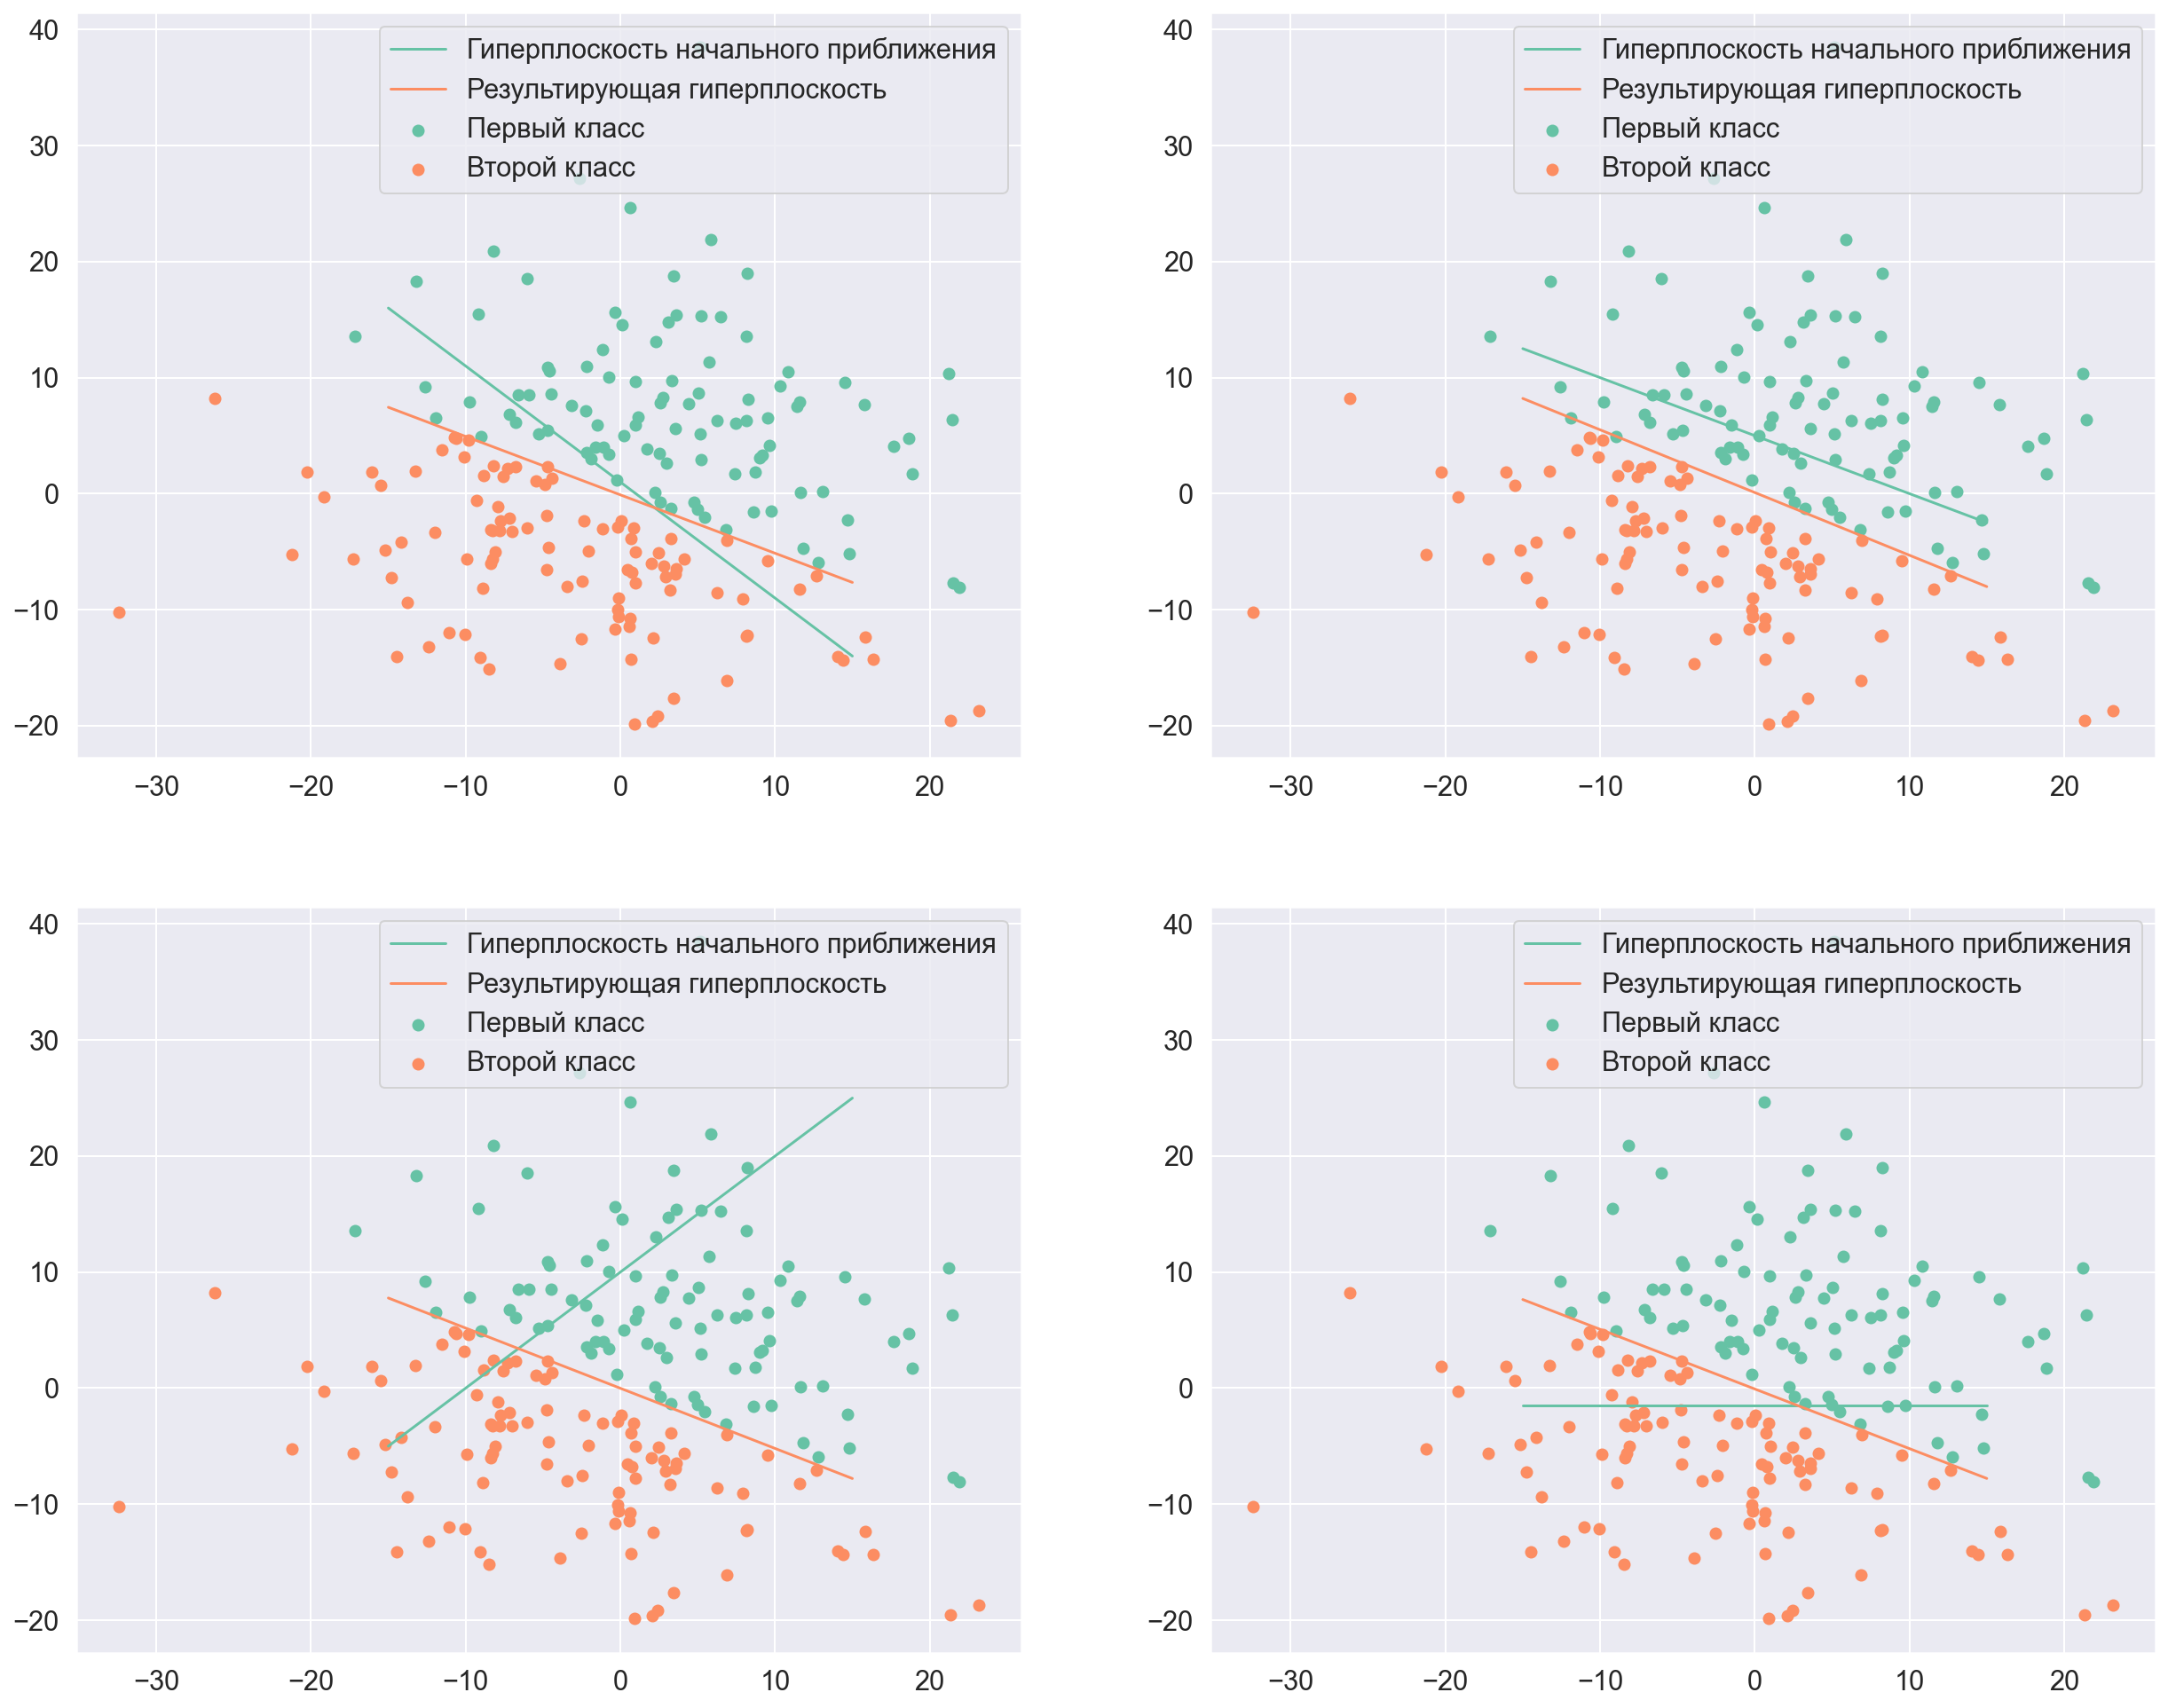

In [21]:
plt.figure(figsize=(21, 17))
for i, w0 in enumerate(different_w0):
    w = newton_rafson_method(X_l, y_l[:, np.newaxis], w0[:, np.newaxis], 0.01)
    w = w.flatten()
    
    plt.subplot(2, 2, i + 1)
    mask = y_l > 0
    plt.scatter(X_l[mask].T[1], X_l[mask].T[2], label='Первый класс')
    plt.scatter(X_l[~mask].T[1], X_l[~mask].T[2], label='Второй класс')
    
    x = np.linspace(-15, 15, 400)
    y0 = (w0[0] - w0[1] * x) / w0[2]
    plt.plot(x, y0, label='Гиперплоскость начального приближения')
    y = (w[0] - w[1] * x) / w[2]
    plt.plot(x, y, label='Результирующая гиперплоскость')
    
    plt.legend(loc='best')
plt.show()

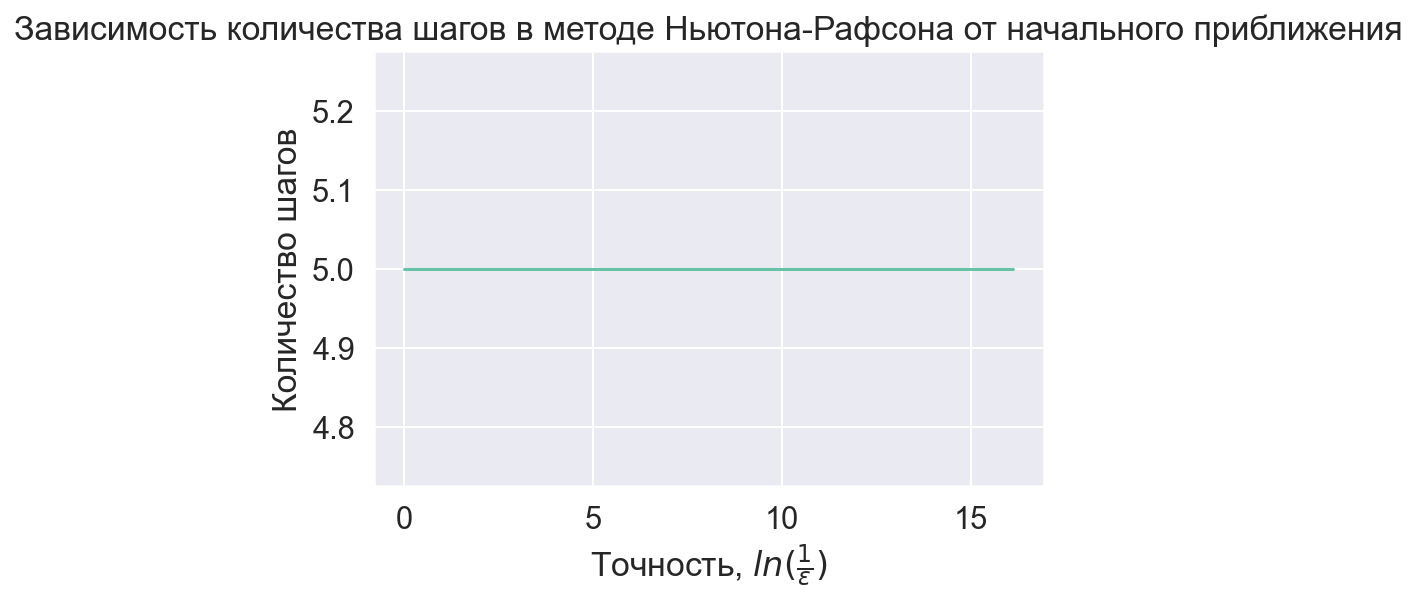

In [22]:
w0 = np.array([[-1],[-1],[-1]])
epsilons = np.linspace(1, 1e-7, 30)
steps = list()
for eps in epsilons:
    w, n_steps = newton_rafson_method(X_l, y_l[:, np.newaxis], w0, 0.01, get_steps=True)
    steps.append(n_steps)
    
plt.title('Зависимость количества шагов в методе Ньютона-Рафсона от начального приближения')
plt.plot(np.log(1/epsilons), steps)
plt.xlabel('Точность, $ln(\\frac{1}{\\varepsilon})$')
plt.ylabel('Количество шагов')
plt.show()

Как мы видим методу Ньютона-Рафсона для получения требуемой точности необходимо одинаковое число шагов.

###  Линейный дискриминантный анализ.

Используем гипотезу линейного дискриминантного анализа – точки каждого класса выбраны из нормального распределения со своим математическим ожиданием и одинаковой дисперсией.

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import shuffle

N=200
LDA_SIGMA = 9
LOC_1 = 10
LOC_2 = -10
w_lda = [0, 1, 1]

In [24]:
def get_LDA_sample():
    X_1 = sps.norm(loc=LOC_1, scale=LDA_SIGMA).rvs(size=(int(N/2), 2))
    X_2 = sps.norm(loc=LOC_2, scale=LDA_SIGMA).rvs(size=(int(N/2), 2))
    X = np.vstack((X_1, X_2))
    X = np.hstack((np.ones(X.shape[0])[:, None], X))
    mask = X[:,1] > 0
    y1 = np.ones((int(N/2),1), dtype=np.int32)
    y2 = np.ones((int(N/2),1), dtype=np.int32) * -1
    y = np.vstack((y1, y2))
    X, y = shuffle(X, y)
    return X, y.ravel()

In [25]:
X_lda, y_lda = get_LDA_sample()

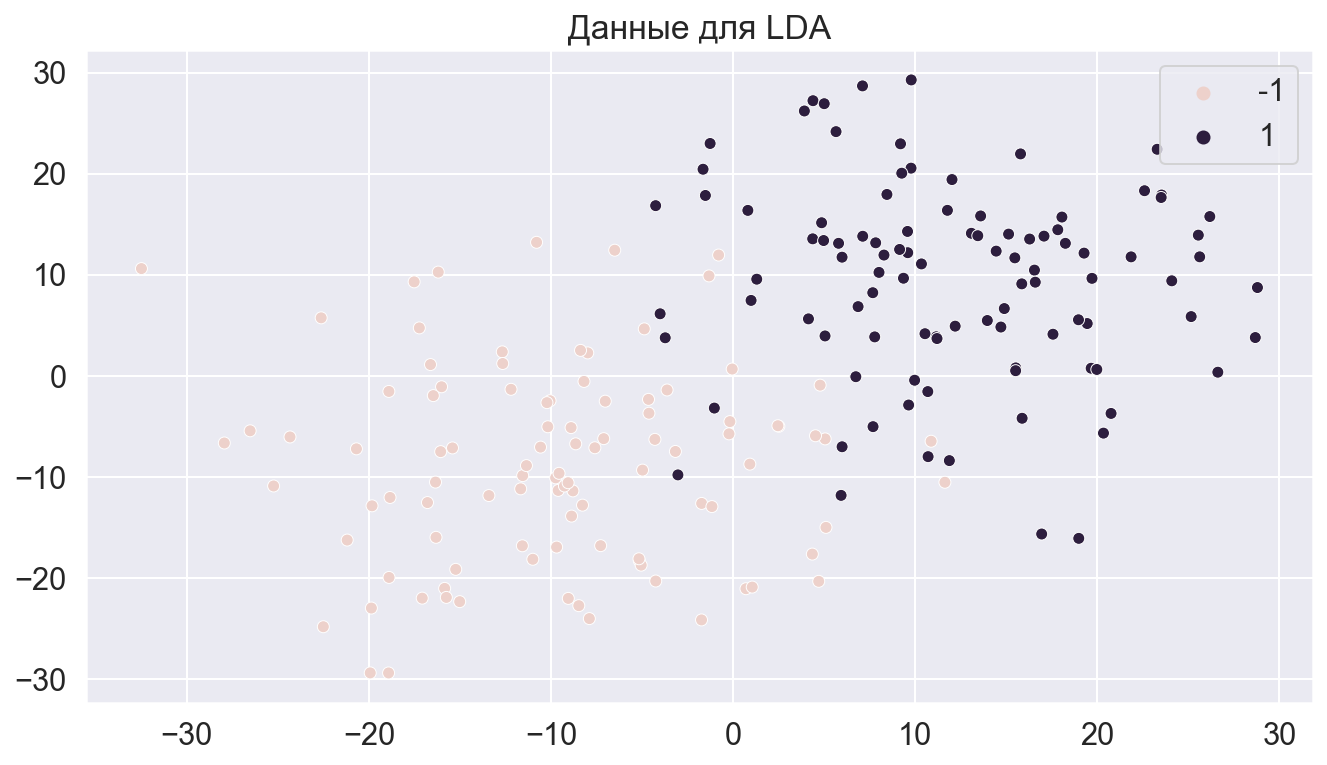

In [26]:
fig, axis = plt.subplots(figsize=(11, 6))
plt.title('Данные для LDA')
sns.scatterplot(x=X_lda[:, 1], y=X_lda[:, 2], hue=y_lda)
plt.show()

In [27]:
w_lda = LinearDiscriminantAnalysis().fit(X_lda, y_lda).coef_.ravel()
w_lda

array([0.        , 0.32906566, 0.20720023])

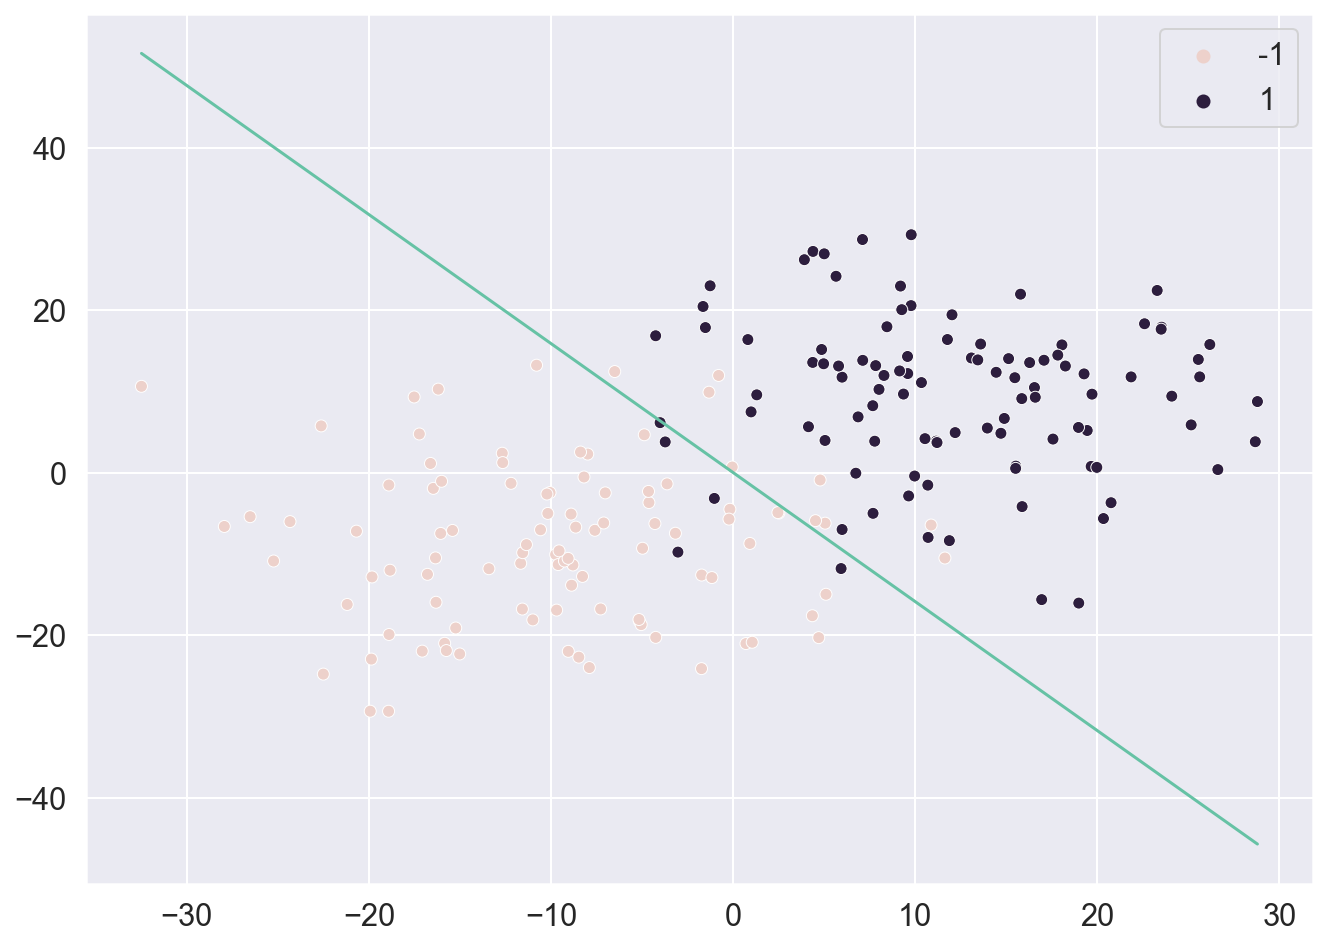

In [28]:
plot_decision_regions(X_lda, y_lda, w_lda)

Сравним результаты Логистической регрессии и LDA подбирая параметры на K-Fold кроссвалидации.

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
cross_val_score(LinearDiscriminantAnalysis(), X_lda, y_lda, cv=5, scoring='accuracy').mean()

0.9349999999999999

In [41]:
cross_val_score(LogRegression(), X_lda, y_lda, cv=5, scoring='accuracy').mean()

0.92086360001


На тесте получилось что LDA дает немного лучшие результаты, но при этом нужно учитывать, что данные имеют нормальное распределение, если бы это было не так, то, конечно же, результаты были бы хуже.

## Применение к задаче машинного обучения

Данные взяты по ссылке, которая [предлагалась в условии задачи](https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738)

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [33]:
columns = ['age', 'workClass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 
           'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
           'native-country', 'income']
train_data = pd.read_csv('adult.data', names=columns, sep=' *, *')
test_data  = pd.read_csv('adult.test', names=columns, sep=' *, *', skiprows=1)

/Users/mikhail/opt/anaconda3/envs/svm/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [34]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Разделим наши данные на два класса. Но перед этим необходимо преобразовать категориальные фичи в числа.

In [35]:
train_data.shape, test_data.shape

((32561, 15), (16281, 15))

In [36]:
X_train = train_data.drop(columns=['income'])
y_train = train_data.income.apply(lambda x: -1 if x=='<=50K' else 1)

X_test = test_data.drop(columns=['income'])
y_test = test_data.income.apply(lambda x: -1 if x=='<=50K.' else 1)

X_train['train'], X_test['train'] = 1, 0

concated = X_train.append(X_test)
categorial = concated.select_dtypes(include=['object']).columns

dummies = pd.get_dummies(concated[categorial])
concated[dummies.columns] = dummies
concated = concated.drop(columns=categorial)

X_train = concated[concated['train'] == 1].drop(columns=['train'])
X_test = concated[concated['train'] == 0].drop(columns=['train'])

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/mikhail/opt/anaconda3/envs/svm/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [37]:
X_train.shape, X_test.shape

((32561, 108), (16281, 108))

In [38]:
X_train[0]

array([ 0.03067056, -1.06361075,  1.13473876,  0.1484529 , -0.21665953,
       -0.03542945, -0.2444502 , -0.17429511, -0.26209736, -0.01466381,
       -1.5167923 , -0.18838933, -0.29093568,  4.90769968, -0.02073999,
       -0.17175325, -0.19348662, -0.11609195, -0.07201601, -0.10164955,
       -0.1422718 , -0.12664495, -0.18406376, -0.21053433,  2.25399324,
       -0.11334387, -0.68994199, -0.23637391, -0.03960742, -0.13419553,
       -0.53714425, -0.39750806, -0.02658695, -0.92284068, -0.11403678,
        1.43105786, -0.1802846 , -0.17735813, -0.24494366,  2.76348874,
       -0.01662771, -0.37949517, -0.37774555, -0.17745022, -0.20957797,
       -0.25595432, -0.33554133, -0.06780164, -0.38166338, -0.14260848,
       -0.35531609, -0.17127887, -0.22710355, -0.82533335,  1.70899099,
       -0.17624972, -0.42934582, -0.34403232, -0.22492681, -0.09820087,
       -0.18155194, -0.32576824, -0.09161163,  0.4130197 , -0.70307135,
        0.70307135, -0.13502327, -0.02416321, -0.06107342, -0.04

Количество колонок увеличилось верно.

In [39]:
lr = LogisticRegression(random_state=42, penalty='l2')
lr = lr.fit(X_train, y_train)

In [40]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred, normalize=True)

0.8525274860266568

Как видиим Логистическая регрессия показала себя очень хорошо. 